# Customer Personality Analysis
This notebook follows the project (based on the YouTube tutorial) and extends it to:
- Use 6 clusters (KMeans)
- Feature engineering (purchase frequency, spending patterns, etc.)
- Train supervised models (RandomForest, XGBoost, LightGBM, MLP) to predict cluster labels
- Hyperparameter tuning (RandomizedSearchCV as example)
- Evaluation with accuracy, precision, recall, F1, ROC-AUC (One-vs-Rest)
- Save models and scaler for the Streamlit app


In [1]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()


In [4]:
# 2. Load data (download from Kaggle and place marketing_campaign.csv in project root)
DATA_PATH = 'marketing_campaign.csv'
if not os.path.exists(DATA_PATH):
    print('Dataset file marketing_campaign.csv not found. Please download from Kaggle and place it in the project folder.')
else:
    df = pd.read_csv('marketing_campaign.csv', sep='\t')

    print('Loaded dataset with shape:', df.shape)
    display(df.head())


Loaded dataset with shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
# 3. Basic preprocessing & feature engineering
def preprocess(df):
    d = df.copy()
    # Drop NA and duplicates
    d = d.dropna()
    # Create TotalSpend as sum of monetary columns (if present)
    money_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
    for c in money_cols:
        if c not in d.columns:
            money_cols = [x for x in money_cols if x in d.columns]
            break
    if len(money_cols) > 0:
        d['Total_Spend'] = d[money_cols].sum(axis=1)
    # Purchase Frequency: sum of purchase count columns
    purchase_cols = ['NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumDealsPurchases']
    purchase_cols = [c for c in purchase_cols if c in d.columns]
    if len(purchase_cols) > 0:
        d['Purchase_Frequency'] = d[purchase_cols].sum(axis=1)
    # Brand preference proxy: number of different product categories purchased
    d['Brand_Preference_Score'] = d[purchase_cols].gt(0).sum(axis=1)
    # Customer tenure if possible
    if 'Dt_Customer' in d.columns:
        d['Dt_Customer'] = pd.to_datetime(d['Dt_Customer'], dayfirst=True, errors='coerce')
        d['Customer_Tenure_Days'] = (pd.to_datetime('today') - d['Dt_Customer']).dt.days.fillna(0)
    # Select numeric features for modeling
    numeric = d.select_dtypes(include=[np.number]).copy().fillna(0)
    return numeric

if os.path.exists(DATA_PATH):
    features = preprocess(df)
    print('Features shape:', features.shape)
    display(features.head())


Features shape: (2216, 30)


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Total_Spend,Purchase_Frequency,Brand_Preference_Score,Customer_Tenure_Days
0,5524,1957,58138.0,0,0,58,635,88,546,172,...,0,0,0,3,11,1,1617,25,4,4813
1,2174,1954,46344.0,1,1,38,11,1,6,2,...,0,0,0,3,11,0,27,6,4,4263
2,4141,1965,71613.0,0,0,26,426,49,127,111,...,0,0,0,3,11,0,776,21,4,4462
3,6182,1984,26646.0,1,0,26,11,4,20,10,...,0,0,0,3,11,0,53,8,3,4289
4,5324,1981,58293.0,1,0,94,173,43,118,46,...,0,0,0,3,11,0,422,19,4,4311


✅ Saved kmeans and scaler


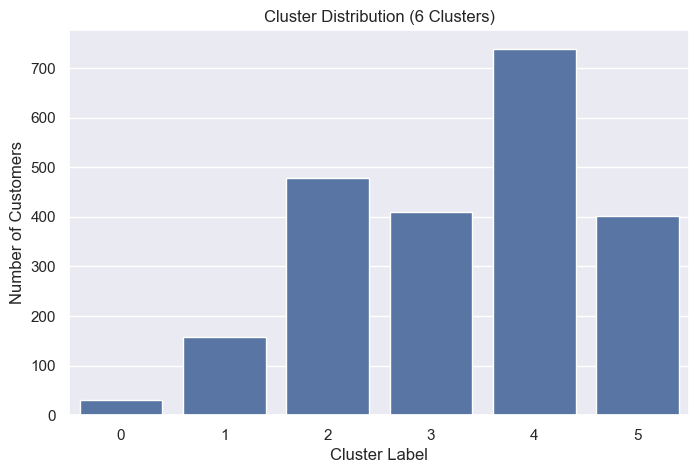

In [7]:
# 4. Scaling and KMeans (6 clusters)
if os.path.exists(DATA_PATH):
    from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, os

# Drop any non-numeric or constant columns
numeric_cols = features.select_dtypes(include=[np.number]).columns
features_cleaned = features[numeric_cols].copy()
features_cleaned = features_cleaned.loc[:, features_cleaned.std() > 0]  # remove zero variance columns

# Scale the cleaned data
scaler = StandardScaler()
X = scaler.fit_transform(features_cleaned.values)

# Run KMeans with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans.fit(X)

# Save labels
features['Cluster'] = kmeans.labels_

# Save model and scaler
os.makedirs('model', exist_ok=True)
joblib.dump(kmeans, 'model/kmeans_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')
print('✅ Saved kmeans and scaler')

# Visualize proper cluster counts
plt.figure(figsize=(8,5))
sns.countplot(x=features['Cluster'])
plt.title("Cluster Distribution (6 Clusters)")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Customers")
plt.show()


In [10]:
# 5. Train supervised classifiers to predict cluster labels
if os.path.exists(DATA_PATH):
    X = features.drop(columns=['Cluster']).values
    y = features['Cluster'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # RandomForest baseline
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Metrics
    print('RandomForest metrics:')
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision (macro): {prec:.3f}")
    print(f"Recall (macro): {rec:.3f}")
    print(f"F1 (macro): {f1:.3f}")

    # ROC-AUC (One-vs-Rest) if possible
    try:
        from sklearn.preprocessing import label_binarize
        y_test_bin = label_binarize(y_test, classes=np.unique(y))
        y_score = rf.predict_proba(X_test)
        roc = roc_auc_score(y_test_bin, y_score, average='macro')
        print(f"ROC-AUC (macro): {roc:.3f}")
    except Exception as e:
        print('ROC-AUC not computed:', e)

    # Save best model
    joblib.dump(rf, 'model/baseline_rf.pkl')
    print('Saved baseline RandomForest')


RandomForest metrics:
Accuracy: 0.941
Precision (macro): 0.780
Recall (macro): 0.788
F1 (macro): 0.783
ROC-AUC (macro): 0.997
Saved baseline RandomForest


In [11]:
# 6. Hyperparameter tuning (example RandomizedSearchCV for RandomForest)
if os.path.exists(DATA_PATH):
    param_dist = {
        'n_estimators': [100,200,300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2,5,10]
    }
    rs = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=6, cv=3, n_jobs=-1, random_state=42)
    rs.fit(X_train, y_train)
    print('Best params (RF):', rs.best_params_)
    best_rf = rs.best_estimator_
    y_pred = best_rf.predict(X_test)
    print('Tuned RF Accuracy:', accuracy_score(y_test, y_pred))
    joblib.dump(best_rf, 'model/best_rf.pkl')


Best params (RF): {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 30}
Tuned RF Accuracy: 0.9481981981981982


In [13]:
# 7. Optional: Train XGBoost and LightGBM (if installed)
if os.path.exists(DATA_PATH):
    try:
        import xgboost as xgb
        xgb_clf = xgb.XGBClassifier(
            eval_metric='mlogloss',
            random_state=42,
            verbosity=0  # hides all warnings
        )
        xgb_clf.fit(X_train, y_train)
        joblib.dump(xgb_clf, 'model/xgb_model.pkl')
        print('✅ Saved XGBoost model')
    except Exception as e:
        print('❌ XGBoost not available or failed:', e)

    try:
        import lightgbm as lgb
        lgb_clf = lgb.LGBMClassifier(random_state=42)
        lgb_clf.fit(X_train, y_train)
        joblib.dump(lgb_clf, 'model/lgb_model.pkl')
        print('✅ Saved LightGBM model')
    except Exception as e:
        print('❌ LightGBM not available or failed:', e)



✅ Saved XGBoost model
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 1772, number of used features: 27
[LightGBM] [Info] Start training from score -4.301810
[LightGBM] [Info] Start training from score -2.651550
[LightGBM] [Info] Start training from score -1.531829
[LightGBM] [Info] Start training from score -1.686851
[LightGBM] [Info] Start training from score -1.098048
[LightGBM] [Info] Start training from score -1.708423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga